In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import shutil
import glob
import math
from collections import Counter

import openpyxl
import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib_venn import venn2
%config InlineBackend.figure_format = 'retina'

import matplotlib.style
import matplotlib as mpl

# Say, "the default sans-serif font is Arial"
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.size'] = 17
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.loc'] = "center left"
mpl.rcParams['figure.facecolor'] = "white"

from lib import parallel_run, geo, misc, seqs, count, gene_ids, align, homer_tools, bedtools, gprofiler, pathway_analysis, homer_logos_table

/tmp/ipykernel_1986316/3404239423.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
folder = "data/ATAC-Seq/hiPSCCM-ERRagKO/"
raw_folder = os.path.join(folder, "FGC2130")
aligned_folder = os.path.join(folder, "aligned")
tags_folder = os.path.join(folder, "tags")
bigwigs_folder = os.path.join(folder, "bigwigs")
peaks_folder = os.path.join(folder, "peaks")
motifs_folder = os.path.join(folder, "motifs")
pics_folder = "pics/atac"

genome_fasta = "reference/Homo_sapiens.GRCh38.dna.toplevel.fa"
homer_genome = "hg38"

sample_info = pd.read_csv(os.path.join(folder, "AAA-StudyInfo.tsv"), sep="\t")
sample_info = sample_info[sample_info.RULA_Run == "FGC2130"]
sample_info.RULA_Lane = sample_info.RULA_Lane.astype(int)
misc.make_sure_folder_exists(tags_folder)
misc.make_sure_folder_exists(bigwigs_folder)
misc.make_sure_folder_exists(peaks_folder)
misc.make_sure_folder_exists(motifs_folder)

In [ ]:
runner = parallel_run.LocalRunner(os.path.join("logs", f"bowtie_align.log"))

for row in tqdm(sample_info.itertuples(), total=len(sample_info)):
    barcode = row.RULA_Barcode
    sample_name = row.SAMP_name
    lane = row.RULA_Lane
    barcode_with_minus = barcode[:8] + "-" + barcode[8:]
    file_name_1 = os.path.join(raw_folder, f"FGC2130_s_{lane}_1_{barcode_with_minus}.fastq.gz")
    file_name_2 = os.path.join(raw_folder, f"FGC2130_s_{lane}_2_{barcode_with_minus}.fastq.gz")
    align.align_chipseq([file_name_1, file_name_2], aligned_folder, genome_fasta, runner, 40)    
    runner.run(dry=False)

In [24]:
for row in tqdm(sample_info.itertuples(), total=len(sample_info)):
    barcode = row.RULA_Barcode
    sample_name = row.SAMP_name
    lane = row.RULA_Lane
    barcode_with_minus = barcode[:8] + "-" + barcode[8:]
    file_name = os.path.join(aligned_folder, f"FGC2130_s_{lane}_1_{barcode_with_minus}.unique1.bam")
    target_file_name = os.path.join(aligned_folder, f"{sample_name}_{lane}.bam")
    os.rename(file_name, target_file_name)
    os.rename(file_name + ".bai", target_file_name + ".bai")


In [ ]:
runner = parallel_run.LocalRunner(os.path.join("logs", f"homer_tags.log"))

for row in tqdm(sample_info.itertuples(), total=len(sample_info)):
    barcode = row.RULA_Barcode
    sample_name = row.SAMP_name
    lane = row.RULA_Lane
    barcode_with_minus = barcode[:8] + "-" + barcode[8:]
    file_name = os.path.join(aligned_folder, f"{sample_name}_{lane}.bam")
    tags_name = os.path.join(tags_folder, f"{sample_name}_{lane}.tags")
    homer_tools.make_tag_directory(file_name, runner, single=True, tag_directory=tags_name)
    runner.run(dry=False)

In [ ]:
runner = parallel_run.LocalRunner(os.path.join("logs", f"homer_pool.log"))

all_samples = frozenset(sample_info.SAMP_name)

for sample_name in tqdm(all_samples):
    file_name1 = os.path.join(tags_folder, f"{sample_name}_1.tags")
    file_name2 = os.path.join(tags_folder, f"{sample_name}_2.tags")
    pooled_name = os.path.join(tags_folder, f"{sample_name}.tags")
    homer_tools.pool_tag_directories([file_name1, file_name2], pooled_name, runner)
    runner.run(dry=False)

In [17]:
runner = parallel_run.LocalRunner(os.path.join("logs", f"homer_pool.log"))

all_samples = frozenset(sample_info.SAMP_name)

for sample_name in tqdm(["Cont", "KO1-", "KO6-"]):
    file_name1 = os.path.join(tags_folder, f"{sample_name}1_ATAC_v2.tags")
    file_name2 = os.path.join(tags_folder, f"{sample_name}2_ATAC_v2.tags")
    pooled_name = os.path.join(tags_folder, f"{sample_name.replace('-', '')}.tags")
    homer_tools.pool_tag_directories([file_name1, file_name2], pooled_name, runner)
    runner.run(dry=False)

Running the following command sequence:
{ makeTagDirectory 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/Cont.tags' -d 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/Cont1_ATAC_v2.tags' 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/Cont2_ATAC_v2.tags' -keepAll -single && echo Finished successfully ; } >> 'logs/homer_pool.log' 2>&1
Running the following command sequence:
{ makeTagDirectory 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/KO1.tags' -d 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/KO1-1_ATAC_v2.tags' 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/KO1-2_ATAC_v2.tags' -keepAll -single && echo Finished successfully ; } >> 'logs/homer_pool.log' 2>&1
Running the following command sequence:
{ makeTagDirectory 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/KO6.tags' -d 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/KO6-1_ATAC_v2.tags' 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/KO6-2_ATAC_v2.tags' -keepAll -single && echo Finished successfully ; } >> 'logs/homer_pool.log' 2>&1



In [ ]:
runner = parallel_run.LocalRunner(os.path.join("logs", f"homer_bigwigs.log"))

all_samples = frozenset(sample_info.SAMP_name)

for sample_name in tqdm(all_samples):
    pooled_name = os.path.join(tags_folder, f"{sample_name}.tags")
    bigwig = homer_tools.make_bigwig(pooled_name, bedtools.chromosome_sizes(genome_fasta), runner, remake=True, sort=False)
    runner.run(dry=False)
    os.rename(bigwig, misc.in_folder(bigwig, bigwigs_folder))

In [86]:
runner = parallel_run.LocalRunner(os.path.join("logs", f"homer_bigwigs.log"))

for sample_name in tqdm(["KO1", "KO6", "Cont"]):
    pooled_name = os.path.join(tags_folder, f"{sample_name}.tags")
    bigwig = homer_tools.make_bigwig(pooled_name, bedtools.chromosome_sizes(genome_fasta), runner, remake=True, sort=False)
    runner.run(dry=False)
    os.rename(bigwig, misc.in_folder(bigwig, bigwigs_folder))

Running the following command sequence:
{ makeUCSCfile 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/KO1.tags' -o auto -bigWig 'reference/Homo_sapiens.GRCh38.dna.toplevel.fa.chrom_sizes'  && echo Finished successfully ; } >> 'logs/homer_bigwigs.log' 2>&1
Running the following command sequence:
{ makeUCSCfile 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/KO6.tags' -o auto -bigWig 'reference/Homo_sapiens.GRCh38.dna.toplevel.fa.chrom_sizes'  && echo Finished successfully ; } >> 'logs/homer_bigwigs.log' 2>&1
Running the following command sequence:
{ makeUCSCfile 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/Cont.tags' -o auto -bigWig 'reference/Homo_sapiens.GRCh38.dna.toplevel.fa.chrom_sizes'  && echo Finished successfully ; } >> 'logs/homer_bigwigs.log' 2>&1



In [14]:
runner = parallel_run.LocalRunner(os.path.join("logs", f"homer_peaks.log"))

all_samples = frozenset(sample_info.SAMP_name)
additional_peak_calling_options = "-region -minDist 150 -gsize 2e9"
for ko_name in ["KO1", "KO6"]:
    ko_tags = [os.path.join(tags_folder, f"{ko_name}-{sid}_ATAC_v2_{lid}.tags") for sid in [1, 2] for lid in [1, 2]]
    control_tags = [os.path.join(tags_folder, f"Cont{sid}_ATAC_v2_{lid}.tags") for sid in [1, 2] for lid in [1, 2]]
    peak_up_file = os.path.join(peaks_folder, f"up_in_{ko_name}.peaks")
    homer_tools.call_peaks_vs_background_with_replicates(ko_tags, control_tags, peak_up_file, runner, additional_options=additional_peak_calling_options)
    peak_down_file = os.path.join(peaks_folder, f"down_in_{ko_name}.peaks")
    homer_tools.call_peaks_vs_background_with_replicates(control_tags, ko_tags, peak_down_file, runner, additional_options=additional_peak_calling_options)
    runner.run(dry=False)

Running the following command sequence:
{ getDifferentialPeaksReplicates.pl   -t 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/KO1-1_ATAC_v2_1.tags' 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/KO1-1_ATAC_v2_2.tags' 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/KO1-2_ATAC_v2_1.tags' 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/KO1-2_ATAC_v2_2.tags' -b 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/Cont1_ATAC_v2_1.tags' 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/Cont1_ATAC_v2_2.tags' 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/Cont2_ATAC_v2_1.tags' 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/Cont2_ATAC_v2_2.tags'  -region -minDist 150 -gsize 2e9 > data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/up_in_KO1.peaks && getDifferentialPeaksReplicates.pl   -t 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/Cont1_ATAC_v2_1.tags' 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/Cont1_ATAC_v2_2.tags' 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/Cont2_ATAC_v2_1.tags' 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/Cont2_ATAC_v2_2.tags' -b 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/KO1-1_ATAC_v2_1.tags' 'data/ATAC-Seq/hiPSCCM-ERRagKO

In [15]:
runner = parallel_run.LocalRunner(os.path.join("logs", f"homer_motifs.log"))
for ko_name in ["KO1", "KO6"]:
    for d in ["up", "down"]:
        peaks_file = os.path.join(peaks_folder, f"{d}_in_{ko_name}.peaks")
        peaks_lchrom_file = peaks_file.replace(".peaks", "_lchrom.peaks")
        homer_tools.to_long_chromnames(peaks_file, peaks_lchrom_file)
        homer_tools.find_motifs(peaks_lchrom_file, homer_genome, "given", os.path.join(motifs_folder, f"{d}_in_{ko_name}.motifs"), runner, 
                                number_of_motifs=15, lengths=[10, 12, 14, 16, 18], threads=14)
        
        runner.run(dry=False)

Running the following command sequence:
{ findMotifsGenome.pl data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/up_in_KO1_lchrom.peaks hg38 data/ATAC-Seq/hiPSCCM-ERRagKO/motifs/up_in_KO1.motifs -size given  -S 15 -len 10,12,14,16,18 -p 14  && echo Finished successfully ; } >> 'logs/homer_motifs.log' 2>&1
Running the following command sequence:
{ findMotifsGenome.pl data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/down_in_KO1_lchrom.peaks hg38 data/ATAC-Seq/hiPSCCM-ERRagKO/motifs/down_in_KO1.motifs -size given  -S 15 -len 10,12,14,16,18 -p 14  && echo Finished successfully ; } >> 'logs/homer_motifs.log' 2>&1
Running the following command sequence:
{ findMotifsGenome.pl data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/up_in_KO6_lchrom.peaks hg38 data/ATAC-Seq/hiPSCCM-ERRagKO/motifs/up_in_KO6.motifs -size given  -S 15 -len 10,12,14,16,18 -p 14  && echo Finished successfully ; } >> 'logs/homer_motifs.log' 2>&1
Running the following command sequence:
{ findMotifsGenome.pl data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/down_in_KO6_lchrom.pea

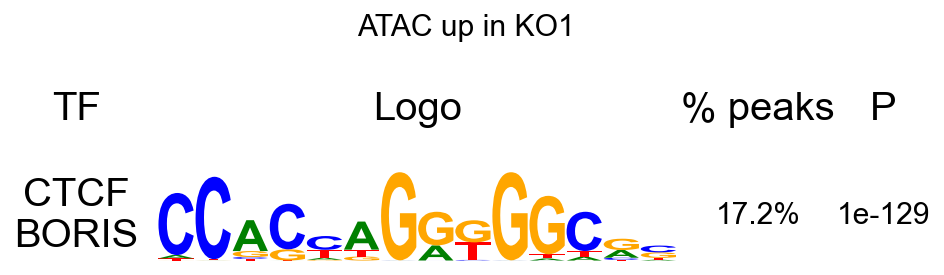

In [10]:
homer_logos_table.make_logos_table("data/ATAC-Seq/hiPSCCM-ERRagKO/motifs/up_in_KO1.motifs/homerResults/", os.path.join(pics_folder, "up_in_KO1_motifs.png"),
                                  ["1+CTCF\nBORIS"], figsize=(8, 2), title="ATAC up in KO1", adjust_top=0.8)

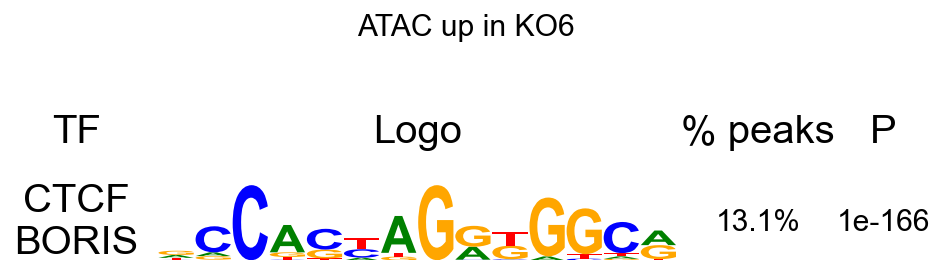

In [11]:
homer_logos_table.make_logos_table("data/ATAC-Seq/hiPSCCM-ERRagKO/motifs/up_in_KO6.motifs/homerResults/", os.path.join(pics_folder, "up_in_KO6_motifs.png"),
                                  ["1+CTCF\nBORIS"], figsize=(8, 2), title="ATAC up in KO6", adjust_top=0.7)

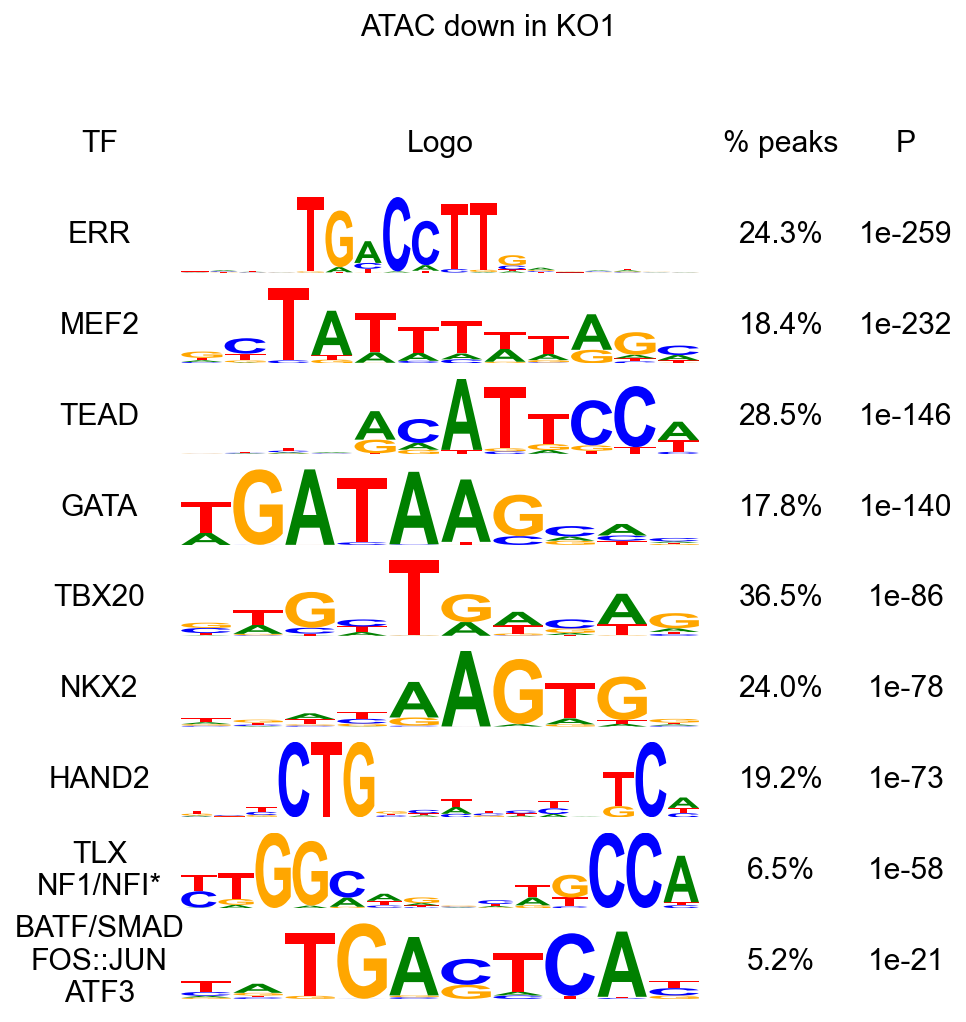

In [8]:
homer_logos_table.make_logos_table("data/ATAC-Seq/hiPSCCM-ERRagKO/motifs/down_in_KO1.motifs/homerResults/", os.path.join(pics_folder, "down_in_KO1_motifs.png"),
                                  ["1+ERR", "2+MEF2", "3+TEAD", "4+GATA", "5+TBX20", "6+NKX2", "7+HAND2", "8+TLX\nNF1/NFI*", "20+BATF/SMAD\nFOS::JUN\nATF3"],
                                   figsize=(8, 8), title="ATAC down in KO1", adjust_top=0.9, label_fontsize=15)

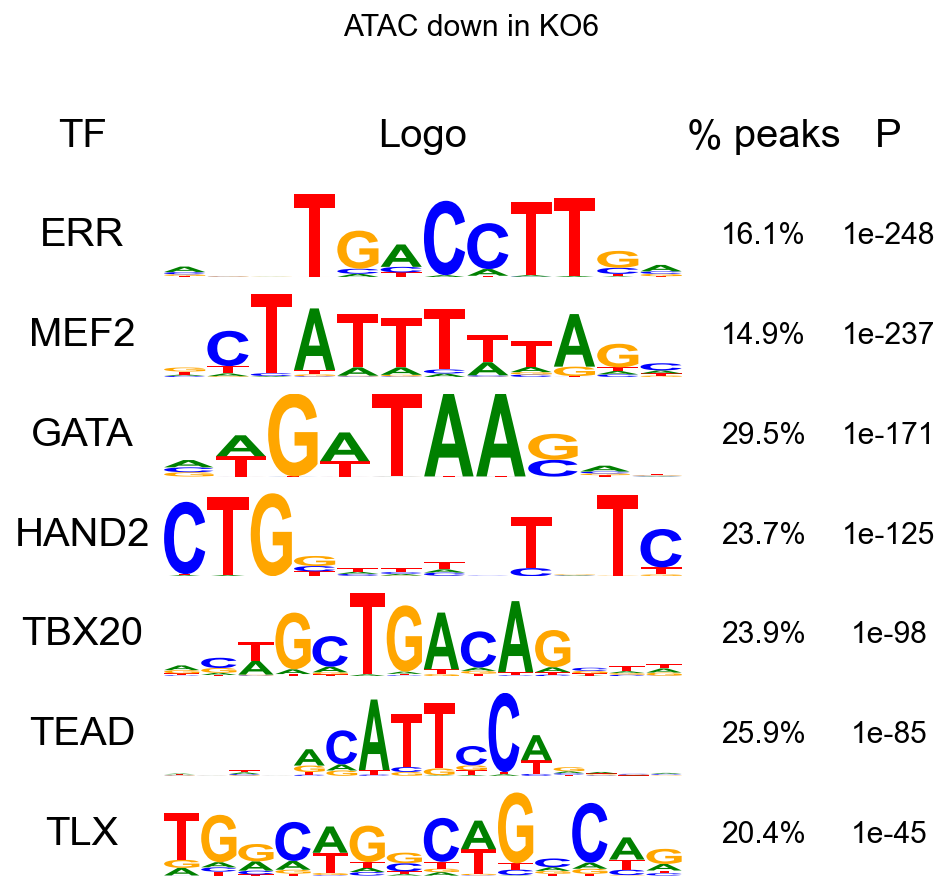

In [9]:
homer_logos_table.make_logos_table("data/ATAC-Seq/hiPSCCM-ERRagKO/motifs/down_in_KO6.motifs/homerResults/", os.path.join(pics_folder, "down_in_KO6_motifs.png"),
                                  ["1+ERR", "2+MEF2", "3+GATA", "4-HAND2", "5+TBX20", "6-TEAD", "10+TLX"], 
                                   figsize=(8, 7), title="ATAC down in KO6", adjust_top=0.9)

In [4]:
runner = parallel_run.LocalRunner(os.path.join("logs", f"homer_annotate.log"))

for ko_name in ["KO1", "KO6"]:
    for d in ["up", "down"]:
        peak_file = os.path.join(peaks_folder, f"{d}_in_{ko_name}_lchrom.peaks")
        annotated_peak_file = os.path.join(peaks_folder, f"{d}_in_{ko_name}_annotated.peaks")
        homer_tools.annotate_peaks(peak_file, annotated_peak_file, homer_genome, runner)
        runner.run()

Running the following command sequence:
{ annotatePeaks.pl 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/up_in_KO1_lchrom.peaks' hg38    > 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/up_in_KO1_annotated.peaks' && echo Finished successfully ; } >> 'logs/homer_annotate.log' 2>&1
Running the following command sequence:
{ annotatePeaks.pl 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/down_in_KO1_lchrom.peaks' hg38    > 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/down_in_KO1_annotated.peaks' && echo Finished successfully ; } >> 'logs/homer_annotate.log' 2>&1
Running the following command sequence:
{ annotatePeaks.pl 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/up_in_KO6_lchrom.peaks' hg38    > 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/up_in_KO6_annotated.peaks' && echo Finished successfully ; } >> 'logs/homer_annotate.log' 2>&1
Running the following command sequence:
{ annotatePeaks.pl 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/down_in_KO6_lchrom.peaks' hg38    > 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/down_in_KO6_annotated.peaks' && echo Fini

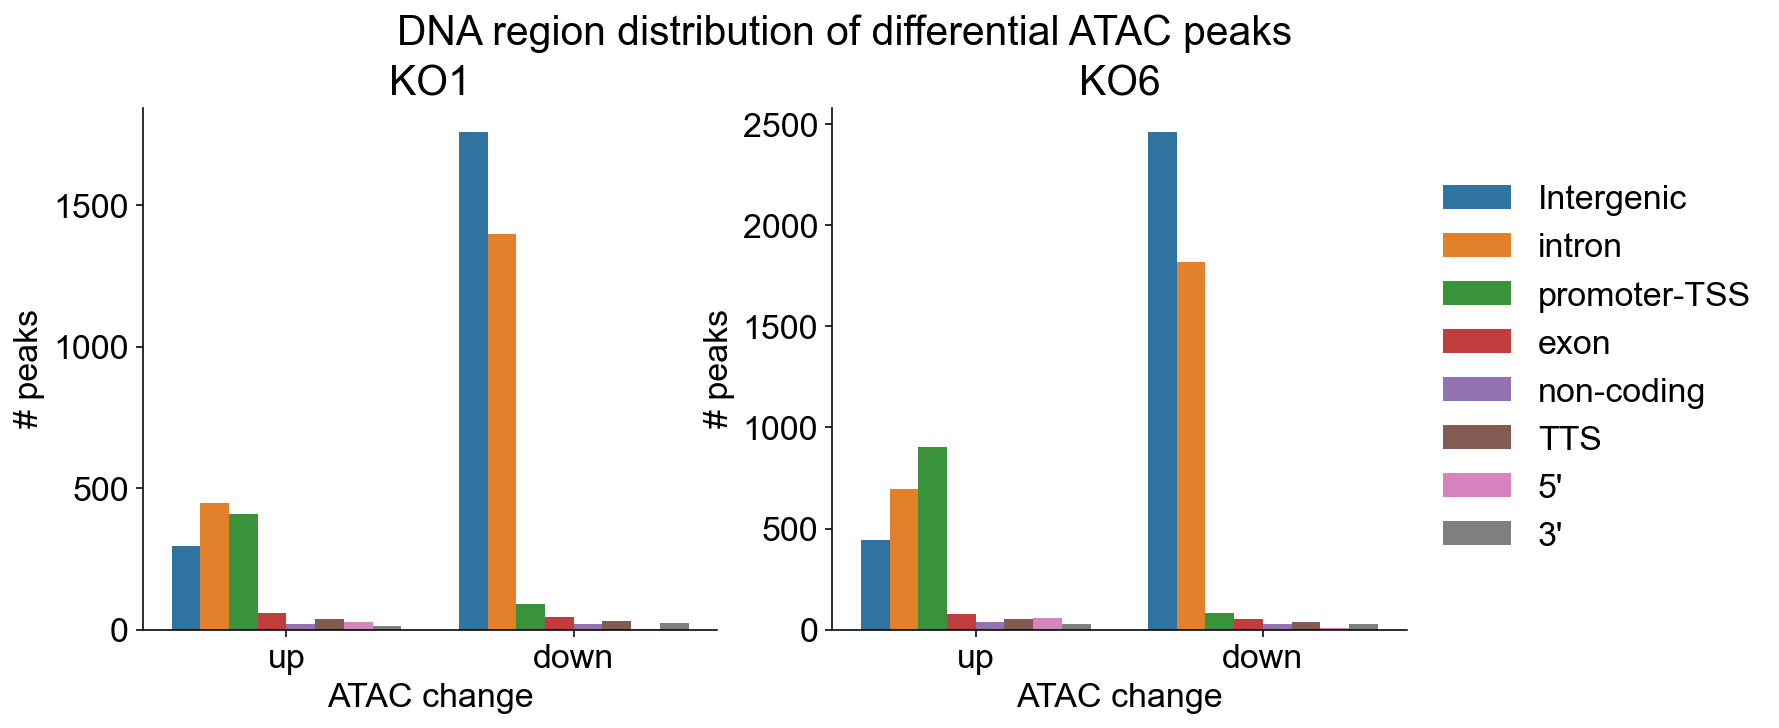

In [36]:
fig = plt.figure(figsize=[13, 5])
gs = GridSpec(1, 2)

all_counts = pd.DataFrame()

for i, ko_name in enumerate(["KO1", "KO6"]):
    ax_name = fig.add_subplot(gs[i])
    plt.title(ko_name)
    counts_df = homer_tools.plot_area_kind_distribution([(d, os.path.join(peaks_folder, f"{d}_in_{ko_name}_annotated.peaks")) for d in ["up", "down"]], "ATAC change")
    if i == 0:
        ax_name.get_legend().remove()
    else:
        plt.legend(bbox_to_anchor=(1.01, 0.5))
        
    counts_df = counts_df.rename(columns={"prop": "# peaks"})
    counts_df["dataset"] = ko_name
    all_counts = pd.concat((all_counts, counts_df))
    
plt.subplots_adjust(right=0.8, top=0.85)
plt.suptitle("DNA region distribution of differential ATAC peaks")
plt.savefig(os.path.join(pics_folder, "region_distribution.png"), dpi=300)
all_counts.to_excel("tables/diff_atac_region_distribution.xlsx", sheet_name="Region counts", index=False)

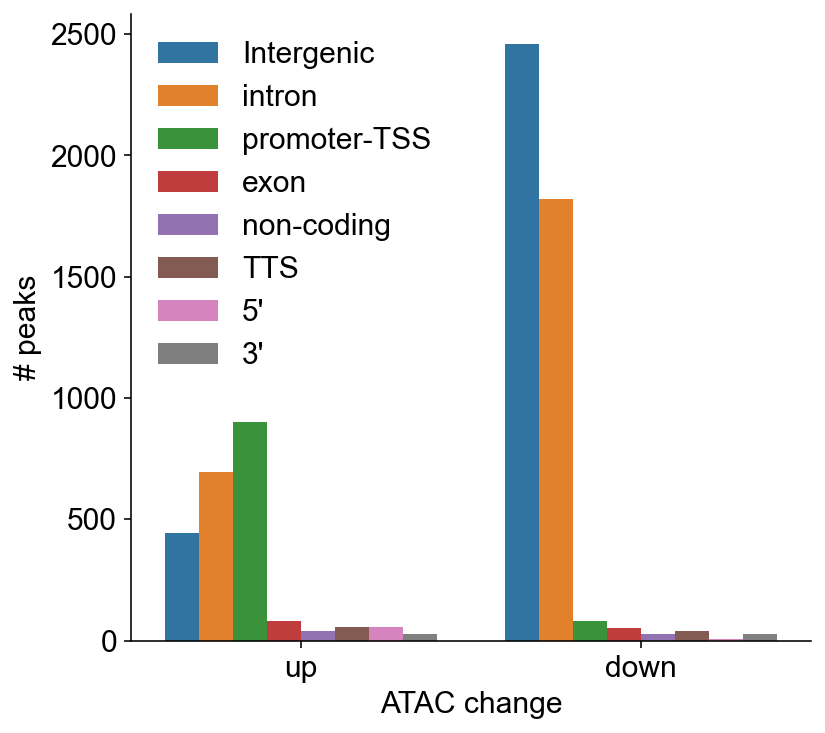

In [12]:
fig = plt.figure(figsize=[7, 6])

all_counts = pd.DataFrame()

for i, ko_name in enumerate(["KO6"]):
    #plt.title(ko_name)
    counts_df = homer_tools.plot_area_kind_distribution([(d, os.path.join(peaks_folder, f"{d}_in_{ko_name}_annotated.peaks")) for d in ["up", "down"]], "ATAC change")
    plt.legend(bbox_to_anchor=(0, 1))
        
    counts_df = counts_df.rename(columns={"prop": "# peaks"})
    counts_df["dataset"] = ko_name
    all_counts = pd.concat((all_counts, counts_df))
    
plt.subplots_adjust(right=0.8, top=0.85)
#plt.suptitle("DNA region distribution of differential ATAC peaks")
#plt.savefig(os.path.join(pics_folder, "region_distribution.png"), dpi=300)
plt.savefig(os.path.join(pics_folder, "region_distribution_KO6.pdf"))
#all_counts.to_excel("tables/diff_atac_region_distribution.xlsx", sheet_name="Region counts", index=False)

Running the following command sequence:
{ mergePeaks -d given 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/up_in_KO1_annotated.peaks' 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled_lchrom.peaks' -matrix 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/up_in_KO1_vs_errg.matrix' -gsize 900000000.0 -venn 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/up_in_KO1_vs_errg.venn' > 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/up_in_KO1_vs_errg.peaks' && echo Finished successfully ; } >> 'logs/homer_merge.log' 2>&1
Running the following command sequence:
{ mergePeaks -d given 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/down_in_KO1_annotated.peaks' 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled_lchrom.peaks' -matrix 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/down_in_KO1_vs_errg.matrix' -gsize 900000000.0 -venn 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/down_in_KO1_vs_errg.venn' > 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/down_in_KO1_vs_errg.peaks' && echo Finished successfully ; } >> 'logs/ho

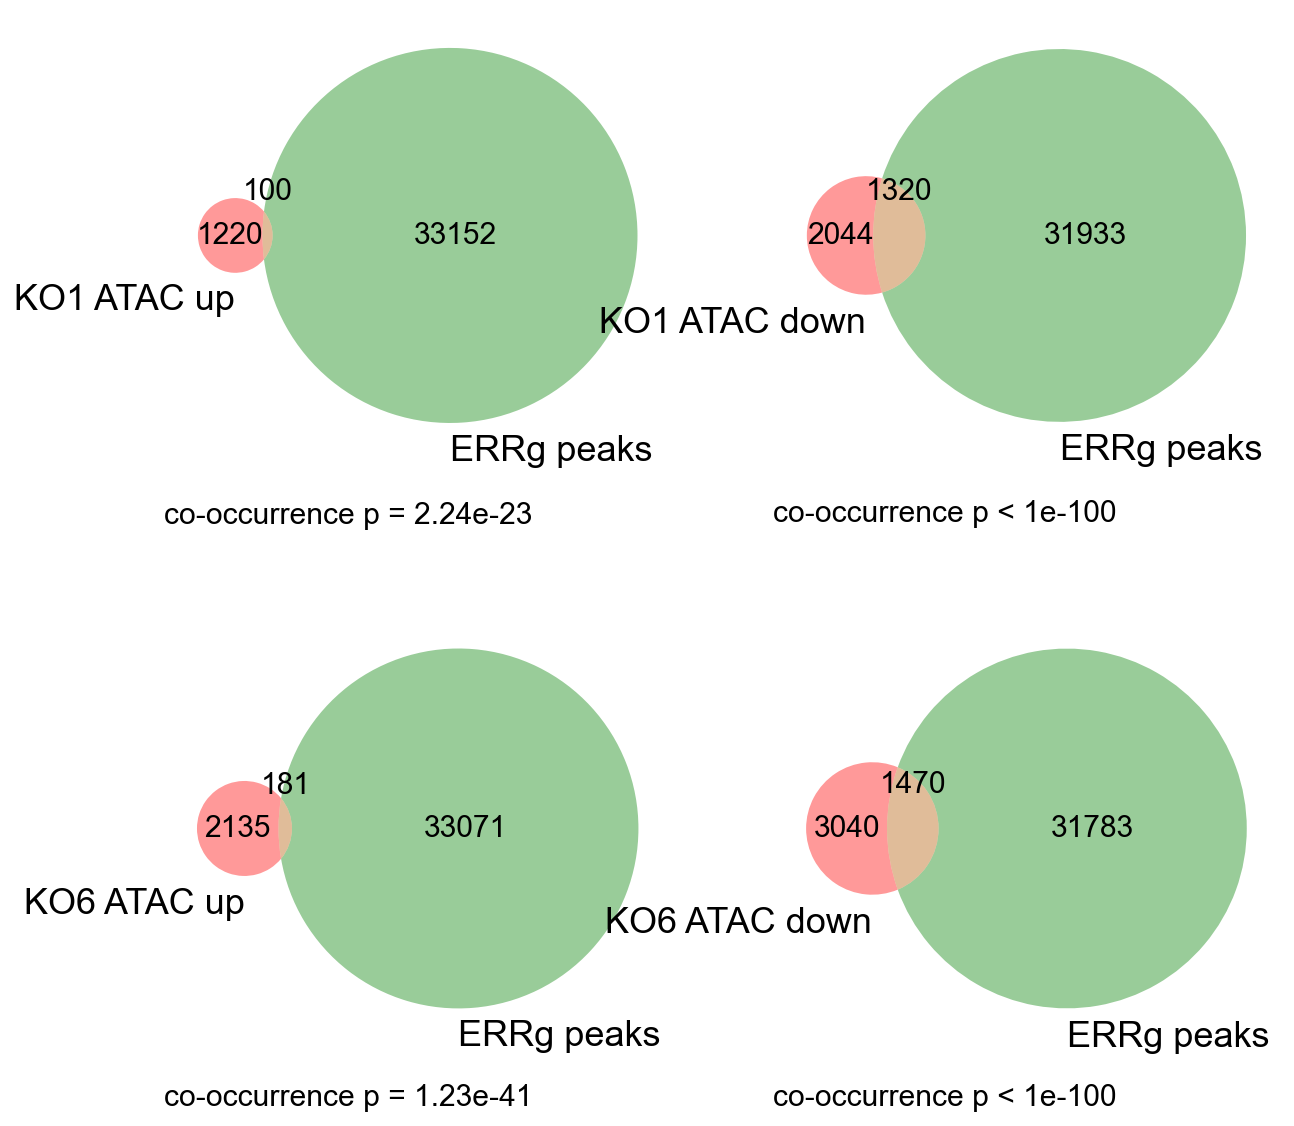

In [7]:
runner = parallel_run.LocalRunner(os.path.join("logs", f"homer_merge.log"))
errg_peaks_file = "data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled_lchrom.peaks"
fig = plt.figure(figsize=[10, 10])
gs = GridSpec(2, 2)

for i, ko_name in enumerate(["KO1", "KO6"]):
    for j, d in enumerate(["up", "down"]):
        annotated_peak_file = os.path.join(peaks_folder, f"{d}_in_{ko_name}_annotated.peaks")
        merged_peak_file = os.path.join(peaks_folder, f"{d}_in_{ko_name}_vs_errg.peaks")
        homer_tools.merge_peaks([annotated_peak_file, errg_peaks_file], merged_peak_file, "given", runner, venn=True, genome_size=9e8)
        runner.run()
        venn_data = pd.read_csv(merged_peak_file.replace(".peaks", ".venn"), sep="\t")
        venn_data = venn_data.set_index("Name")
        ax = fig.add_subplot(gs[i * 2 + j])
        sets = Counter()
        sets["10"] = venn_data.loc[annotated_peak_file, "Total"]
        sets["01"] = venn_data.loc[errg_peaks_file, "Total"]
        sets["11"] = venn_data.loc[annotated_peak_file + "|" + errg_peaks_file, "Total"]
        
        v = venn2(subsets=sets, set_labels=[f"{ko_name} ATAC {d}", f"ERRg peaks"])
        lbl = v.get_label_by_id("11")
        x, y = lbl.get_position()
        lbl.set_position((x, y + 0.13))
        
        for ii in sets:
            v.get_label_by_id(ii).set_fontsize(15)
            
        pval_matrix_file = misc.replace_extension(merged_peak_file, "matrix.logPvalue.matrix.txt")
        pval_data = pd.read_csv(pval_matrix_file, sep="\t")
        p_value = np.exp(float(pval_data.iloc[0, 2]))
        if p_value < 1e-100:
            pval_text = "< 1e-100"
        elif p_value >= 1:
            pval_text = "non-sig."
        else:
            pval_text = f"= {p_value:.3g}"

        plt.figtext(0, -0.15, f"co-occurrence p {pval_text}", transform=plt.gca().transAxes)
            
        
        #h, l = [],[]
        #for ii in sets:
            # remove label by setting them to empty string:
        #    v.get_label_by_id(ii).set_text("")
            # append patch to handles list
        #    h.append(v.get_patch_by_id(ii))
            # append count to labels list
        #    l.append(sets[ii])

        #create legend from handles and labels    
        #ax.legend(handles=h, labels=l, title="counts")
        
        
plt.savefig(os.path.join(pics_folder, "atac_vs_errg_peaks_venn.png"), dpi=300)

In [76]:
workbook_file = "tables/ATAC-Seq_genes.xlsx"
wb = openpyxl.Workbook()
go_pics_folder = os.path.join(pics_folder, "GO")
misc.make_sure_folder_exists(go_pics_folder)

for i, ko_name in enumerate(["KO1", "KO6"]):
    for j, d in enumerate(["up", "down"]):
        annotated_peak_file = os.path.join(peaks_folder, f"{d}_in_{ko_name}_annotated.peaks")
        peak_data = pd.read_csv(annotated_peak_file, sep="\t")
        
        ws = wb.create_sheet(f"{ko_name}|{d} nearest genes")
        genes_data = peak_data.loc[:, ["Nearest Refseq", 'Gene Name']]
        genes_data = genes_data.loc[~pd.isnull(genes_data["Nearest Refseq"]), :]
        genes_data.drop_duplicates(subset="Nearest Refseq", inplace=True)
        genes_data.sort_values(by="Gene Name", inplace=True)
        misc.write_dataframe_to_worksheet(ws, genes_data)
        
        genes = set(genes_data["Nearest Refseq"])
        res = gprofiler.plot_significant_results(genes, gprofiler.main_libraries, gprofiler.organisms["human"], enrichment_cutoff=2, enrichment_alpha=0.05, 
                                                 pics_folder=go_pics_folder, suffix=f"_{ko_name}_{d}", return_genes=True)
        
        gprofiler.write_res_from_libraries(wb.create_sheet(f"{ko_name}|{d} GO"), res, gprofiler.main_libraries, enrichment_cutoff=2, 
                                           gene_name_map=dict(zip(genes_data["Nearest Refseq"], genes_data["Gene Name"])))

del wb["Sheet"]
wb.save(workbook_file)

Enrichment analysis for 1119 genes in KEGG pathways...
Enrichment analysis for 1119 genes in Molecular function...
No data for pics/atac/GO/GO:MF_KO1_up.png
Enrichment analysis for 1119 genes in Cellular component...
Enrichment analysis for 1119 genes in Biological process...
Enrichment analysis for 2394 genes in KEGG pathways...
Enrichment analysis for 2394 genes in Molecular function...
Enrichment analysis for 2394 genes in Cellular component...
Enrichment analysis for 2394 genes in Biological process...
Enrichment analysis for 1883 genes in KEGG pathways...
Enrichment analysis for 1883 genes in Molecular function...
Enrichment analysis for 1883 genes in Cellular component...
Enrichment analysis for 1883 genes in Biological process...
Enrichment analysis for 2902 genes in KEGG pathways...
Enrichment analysis for 2902 genes in Molecular function...
Enrichment analysis for 2902 genes in Cellular component...
Enrichment analysis for 2902 genes in Biological process...


In [83]:
runner = parallel_run.LocalRunner(os.path.join("logs", f"homer_annotate.log"))

for i, ko_name in enumerate(["KO1", "KO6"]):
    for j, d in enumerate(["up", "down"]):
        joined_peaks = pd.read_csv(os.path.join(peaks_folder, f"{d}_in_{ko_name}_vs_errg.peaks"), sep="\t", dtype=str)
        both_peaks = joined_peaks[joined_peaks["Total subpeaks"] != "1"]
        both_peaks_file = os.path.join(peaks_folder, f"{d}_in_{ko_name}_with_errg.peaks")
        both_peaks.to_csv(both_peaks_file, sep="\t", index=False)
        both_annotated = os.path.join(peaks_folder, f"{d}_in_{ko_name}_with_errg_annotated.peaks")
        homer_tools.annotate_peaks(both_peaks_file, both_annotated, homer_genome, runner)
        runner.run()

Running the following command sequence:
{ annotatePeaks.pl 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/up_in_KO1_with_errg.peaks' hg38    > 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/up_in_KO1_with_errg_annotated.peaks' && echo Finished successfully ; } >> 'logs/homer_annotate.log' 2>&1
Running the following command sequence:
{ annotatePeaks.pl 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/down_in_KO1_with_errg.peaks' hg38    > 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/down_in_KO1_with_errg_annotated.peaks' && echo Finished successfully ; } >> 'logs/homer_annotate.log' 2>&1
Running the following command sequence:
{ annotatePeaks.pl 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/up_in_KO6_with_errg.peaks' hg38    > 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/up_in_KO6_with_errg_annotated.peaks' && echo Finished successfully ; } >> 'logs/homer_annotate.log' 2>&1
Running the following command sequence:
{ annotatePeaks.pl 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/down_in_KO6_with_errg.peaks' hg38    > 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks

In [85]:
workbook_file = "tables/ATAC-Seq_with_ERRg_genes.xlsx"
wb = openpyxl.Workbook()
go_pics_folder = os.path.join(pics_folder, "GO_with_errg")
misc.make_sure_folder_exists(go_pics_folder)

for i, ko_name in enumerate(["KO1", "KO6"]):
    for j, d in enumerate(["up", "down"]):
        annotated_peak_file = os.path.join(peaks_folder, f"{d}_in_{ko_name}_with_errg_annotated.peaks")
        peak_data = pd.read_csv(annotated_peak_file, sep="\t")
        
        ws = wb.create_sheet(f"{ko_name}|{d} nearest genes")
        genes_data = peak_data.loc[:, ["Nearest Refseq", 'Gene Name']]
        genes_data = genes_data.loc[~pd.isnull(genes_data["Nearest Refseq"]), :]
        genes_data.drop_duplicates(subset="Nearest Refseq", inplace=True)
        genes_data.sort_values(by="Gene Name", inplace=True)
        misc.write_dataframe_to_worksheet(ws, genes_data)
        
        genes = set(genes_data["Nearest Refseq"])
        res = gprofiler.plot_significant_results(genes, gprofiler.main_libraries, gprofiler.organisms["human"], enrichment_cutoff=2, enrichment_alpha=0.05, 
                                                 pics_folder=go_pics_folder, suffix=f"_{ko_name}_{d}", return_genes=True)
        
        gprofiler.write_res_from_libraries(wb.create_sheet(f"{ko_name}|{d} GO"), res, gprofiler.main_libraries, enrichment_cutoff=2, 
                                           gene_name_map=dict(zip(genes_data["Nearest Refseq"], genes_data["Gene Name"])))

del wb["Sheet"]
wb.save(workbook_file)

Enrichment analysis for 98 genes in KEGG pathways...
No data for pics/atac/GO_with_errg/KEGG_KO1_up.png
Enrichment analysis for 98 genes in Molecular function...
No data for pics/atac/GO_with_errg/GO:MF_KO1_up.png
Enrichment analysis for 98 genes in Cellular component...
No data for pics/atac/GO_with_errg/GO:CC_KO1_up.png
Enrichment analysis for 98 genes in Biological process...
No data for pics/atac/GO_with_errg/GO:BP_KO1_up.png
No results to put to worksheet
Enrichment analysis for 1155 genes in KEGG pathways...
Enrichment analysis for 1155 genes in Molecular function...
Enrichment analysis for 1155 genes in Cellular component...
Enrichment analysis for 1155 genes in Biological process...
Enrichment analysis for 179 genes in KEGG pathways...
No data for pics/atac/GO_with_errg/KEGG_KO6_up.png
Enrichment analysis for 179 genes in Molecular function...
No data for pics/atac/GO_with_errg/GO:MF_KO6_up.png
Enrichment analysis for 179 genes in Cellular component...
No data for pics/atac/GO_

In [87]:
de_data = pd.read_excel("tables/ERRag_KO_hiPSC-CM_de_result_tables.xlsx", sheet_name="FPKM")

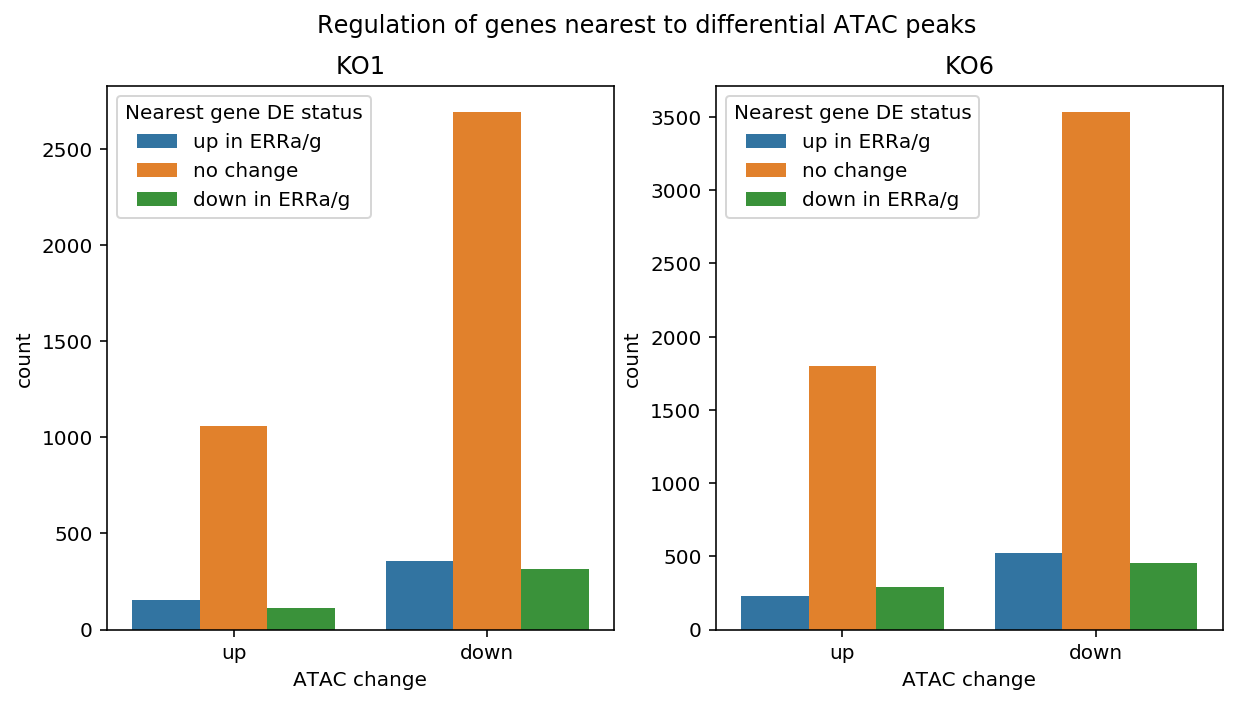

In [112]:
min_logfc = math.log2(1.5)
fig = plt.figure(figsize=[10, 5])
gs = GridSpec(1, 2)

for i, ko_name in enumerate(["KO1", "KO6"]):
    qs = de_data[f"{ko_name} vs. WT padj"]
    logfc = de_data[f"{ko_name} vs. WT log2FoldChange"]
    genes_up = de_data.loc[(qs < 0.05) & (logfc > min_logfc), "gene_id"]
    genes_down = de_data.loc[(qs < 0.05) & (logfc < -min_logfc), "gene_id"]
        
    ko_gene_dirs = []
    ko_atac_dirs = []
    for j, d in enumerate(["up", "down"]):
        annotated_peak_file = os.path.join(peaks_folder, f"{d}_in_{ko_name}_annotated.peaks")
        peak_data = pd.read_csv(annotated_peak_file, sep="\t")        
        peak_data["gene_dir"] = "no change"
        peak_data.loc[np.in1d(peak_data["Nearest Ensembl"], genes_up), "gene_dir"] = "up in ERRa/g"
        peak_data.loc[np.in1d(peak_data["Nearest Ensembl"], genes_down), "gene_dir"] = "down in ERRa/g"
        ko_gene_dirs.extend(peak_data.gene_dir)
        ko_atac_dirs.extend([d] * len(peak_data))

    ax_name = fig.add_subplot(gs[i])
    plt.title(ko_name)
    sns.countplot(x="ATAC change", hue="Nearest gene DE status", data=pd.DataFrame({"Nearest gene DE status": ko_gene_dirs, "ATAC change": ko_atac_dirs}), 
                  hue_order=["up in ERRa/g", "no change", "down in ERRa/g"])
    
plt.suptitle("Regulation of genes nearest to differential ATAC peaks")
plt.savefig(os.path.join(pics_folder, "de_gene_distribution.png"), dpi=300)        

In [6]:
runner = parallel_run.LocalRunner(os.path.join("logs", f"atac_peaks.log"), threads=15)
for gt in ["Cont", "KO1-", "KO6-"]:
    for biol_rep in [1, 2]:
        for tech_rep in [1, 2]:
            tags = f"data/ATAC-Seq/hiPSCCM-ERRagKO/tags/{gt}{biol_rep}_ATAC_v2_{tech_rep}.tags/"
            peaks_file = f"data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/{gt.replace('-', '')}{biol_rep}_ATAC_v2_{tech_rep}.peaks"
            homer_tools.find_peaks(tags, peaks_file, runner, peak_size=1000, min_tags_per_peak=19)
            runner.run()

Running the following command sequence:
{ findPeaks 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/Cont1_ATAC_v2_1.tags/' -size 1000     -o 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/Cont1_ATAC_v2_1.peaks' -minTagThreshold 19   && echo Finished successfully ; } >> 'logs/atac_peaks.log' 2>&1
Running the following command sequence:
{ findPeaks 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/Cont1_ATAC_v2_2.tags/' -size 1000     -o 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/Cont1_ATAC_v2_2.peaks' -minTagThreshold 19   && echo Finished successfully ; } >> 'logs/atac_peaks.log' 2>&1
Running the following command sequence:
{ findPeaks 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/Cont2_ATAC_v2_1.tags/' -size 1000     -o 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/Cont2_ATAC_v2_1.peaks' -minTagThreshold 19   && echo Finished successfully ; } >> 'logs/atac_peaks.log' 2>&1
Running the following command sequence:
{ findPeaks 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/Cont2_ATAC_v2_2.tags/' -size 1000     -o 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/Cont2_ATA

In [7]:
for gt in ["Cont", "KO1", "KO6"]:
    intersection_bed = f"data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/{gt}_intersection.bed"
    if os.path.exists(intersection_bed):
        os.remove(intersection_bed)

    for biol_rep in [1, 2]:
        for tech_rep in [1, 2]:
            peaks_file = f"data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/{gt}{biol_rep}_ATAC_v2_{tech_rep}.peaks"
            current_bed = "data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/current.bed"
            homer_tools.peak_file_to_bed(peaks_file, runner=parallel_run.SimpleRunner(), output_bed=current_bed)

            if not os.path.exists(intersection_bed):
                shutil.copy(current_bed, intersection_bed)
            else:
                intersection_bed_2 = f"data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/{gt}_intersection_2.bed"
                bedtools.intersect(current_bed, intersection_bed, runner=parallel_run.SimpleRunner(), output=intersection_bed_2)
                os.remove(intersection_bed)
                os.rename(intersection_bed_2, intersection_bed)

            os.remove(current_bed)

    intersection_peaks = f"data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/{gt}_intersection.peaks"
    !bed2pos.pl {intersection_bed} > {intersection_peaks}
    !rm {intersection_bed}

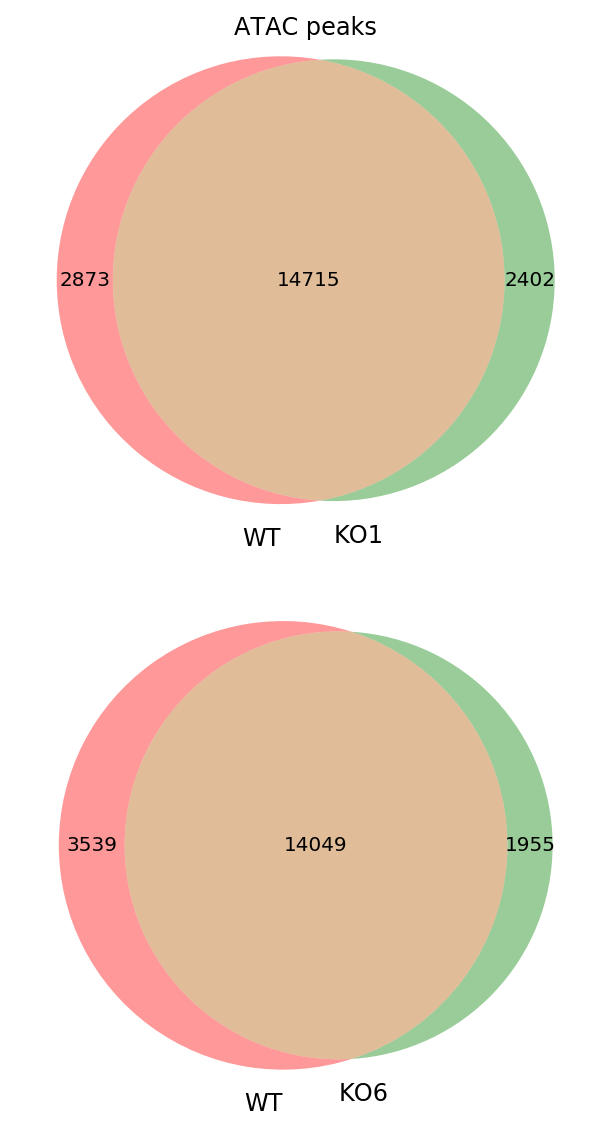

In [15]:
plt.figure(figsize=(6, 8))
for i, ko in enumerate(["KO1", "KO6"]):
    plt.subplot(211 + i)
    homer_tools.compare_peaks(f"data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/Cont_intersection.peaks", f"data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/{ko}_intersection.peaks",
                             "WT", ko)
    
plt.suptitle("ATAC peaks")
plt.tight_layout()
plt.savefig("pics/atac/condition_atac_intersection.png", dpi=300)

Running command w/120 threads: mergePeaks -d given 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/Cont_intersection.peaks' 'data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/peaks/H3K27Ac_WT_vs_Input_pooled.peaks' -matrix 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/Cont_intersection.peaks.merged.matrix'-gsize 900000000.0 -venn 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/Cont_intersection.peaks.merged.venn' > 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/Cont_intersection.peaks.merged.peaks'


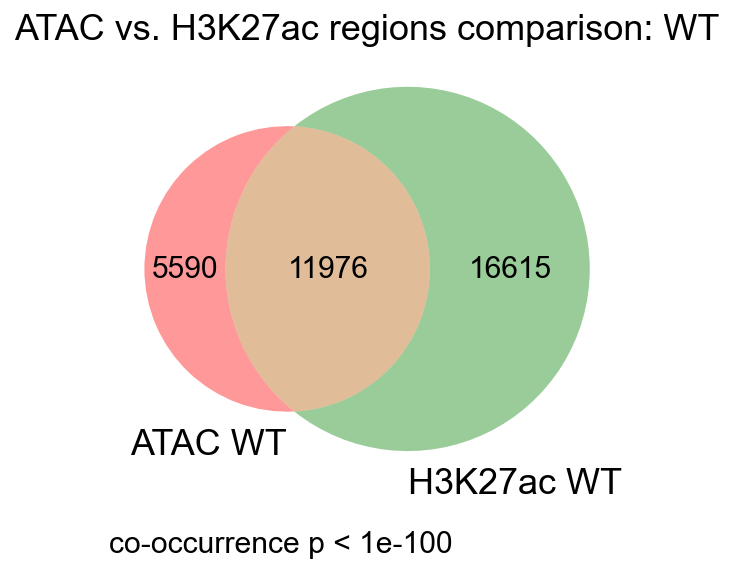

In [6]:
homer_tools.compare_peaks(f"data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/Cont_intersection.peaks", 
                          f"data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/peaks/H3K27Ac_WT_vs_Input_pooled.peaks",
                          "ATAC WT", "H3K27ac WT", genome_size=9e8)

plt.title("ATAC vs. H3K27ac regions comparison: WT")
plt.savefig("pics/atac/atac_h2k27ac_wt_intersection.png", dpi=300)

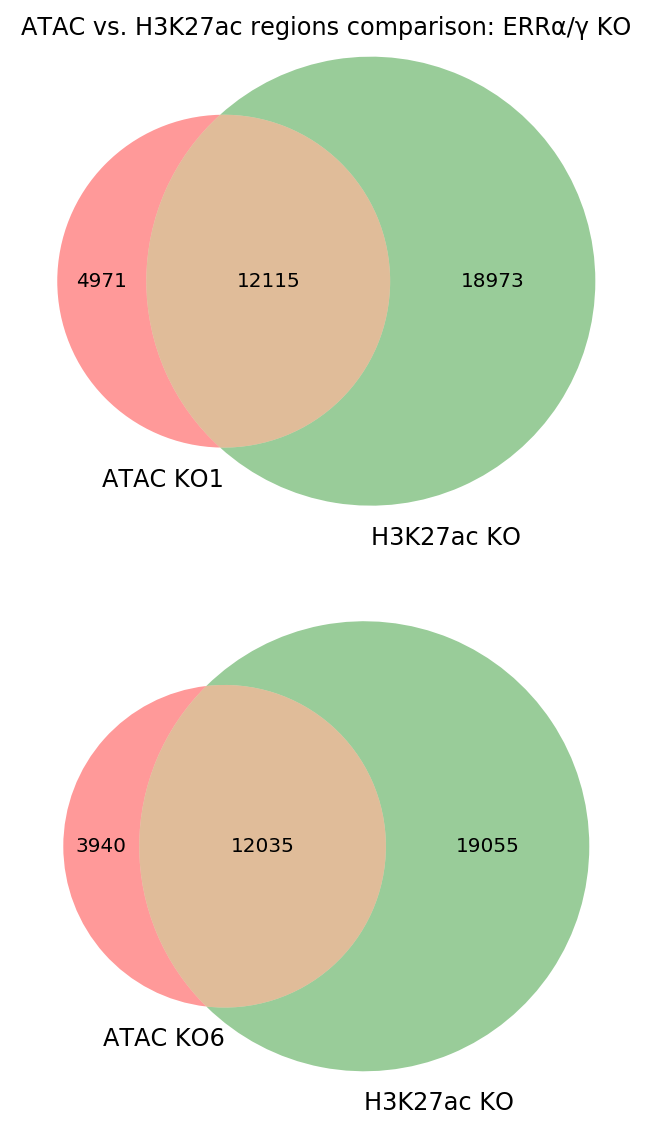

In [23]:
plt.figure(figsize=(6, 8))
for i, ko in enumerate(["KO1", "KO6"]):
    plt.subplot(211 + i)
    homer_tools.compare_peaks(f"data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/{ko}_intersection.peaks", 
                              f"data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/peaks/H3K27Ac_KO_vs_Input_pooled.peaks",
                              f"ATAC {ko}", "H3K27ac KO")

plt.suptitle("ATAC vs. H3K27ac regions comparison: ERRα/γ KO")
plt.tight_layout()
plt.savefig("pics/atac/atac_h2k27ac_ko_intersection.png", dpi=300)